# Generating Shakespearean Text Using a Character RNN

In a famous [2015 blog post](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) titled “The Unreasonable Effectiveness of Recurrent Neural Networks,” Andrej Karpathy showed how to train an RNN to predict the next character in a sentence

This **Char-RNN** can then be used to generate novel text, one character at a time

## Creating the Training Dataset

First, let’s download all of Shakespeare’s work, using Keras’s handy get_file() function and downloading the data from Andrej Karpathy’ [Char-RNN project](https://github.com/karpathy/char-rnn):

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1130496/1115394 [==============================] - 0s 0us/step


In [3]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



Next, we must encode every character as an integer. One option is to create a custom preprocessing layer, as we did in Chapter 13

But in this case, it will be simpler to use Keras’ Tokenizer class. First we need to fit a **tokenizer** to the text: **it will find all the characters used in the text and map each of them to a different character ID, from 1 to the number of distinct characters** (it does not start at 0, so we can use that value for masking, as we will see later in this chapter):

In [4]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

We set **char_level=True** to get **character-level encoding rather than the default word-level encoding**. Note that this **tokenizer converts the text to lowercase by default** (but you can set lower=False if you do not want that)

Now the tokenizer can encode a sentence (or a list of sentences) to a list of character IDs and back, and it tells us how many distinct characters there are and the total number of characters in the text:

In [5]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [6]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [7]:
max_id = len(tokenizer.word_index) # number of distinct characters
max_id

39

In [8]:
dataset_size = tokenizer.document_count # total number of characters
dataset_size

1115394

Let’s encode the full text so each character is represented by its ID (we subtract 1 to get IDs from 0 to 38, rather than from 1 to 39):

In [9]:
import numpy as np
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

Before we continue, we need to split the dataset into a training set, a validation set, and a test set. We **can’t just shuffle all the characters in the text,** so how do you split a sequential dataset?

## How to Split a Sequential Dataset

For example, we can take the first 90% of the text for the training set, then the next 5% for the validation set, and the final 5% for the test set

It would also be a good idea to **leave a gap between these sets** to **avoid** the risk of a **paragraph overlapping** over two sets

When dealing with time series, you would in **general split across time,:** for example, you might take the years **2000 to 2012 for the training set, the years 2013 to 2015 for the validation set, and the years 2016 to 2018 for the test set.** However, in some cases you may be able to split along other dimensions, which will give you a longer time period to train on

So, it is often safer to split across time—but this implicitly **assumes that the patterns the RNN can learn in the past** (in the training set) **will still exist in the future.** In other words, we assume that the time series is **stationary**

For many time series this assumption is reasonable **(e.g., chemical reactions should be fine, since the laws of chemistry don’t change every day),** but f**or many others it is not (e.g., financial markets are notoriously not stationary since patterns disappear as soon as traders spot them and start exploiting them)**

To **make sure** the time series is indeed sufficiently **stationary,** you can **plot the model’s errors on the validation set across time: if the model performs much better on the first part of the validation set than on the last part, then the time series may not be stationary enough,** and you might be **better off training the model on a shorter time span.**

Now back to Shakespeare! Let’s take the first 90% of the text for the training set (keeping the rest for the validation set and the test set), and create a tf.data.Dataset that will return each character one by one from this set:

In [10]:
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

## Chopping the Sequential Dataset into Multiple Windows

The training set now consists of a single sequence of **over a million characters,** so we **can’t just train the neural network directly** on it: **the RNN would be equivalent to a deep net with over a million layers,** and we would have a single (very long) instance to train it

Instead, we will use the dataset’s **window() method** to **convert** this long sequence of characters **into many smaller windows of text**

**Every instance** in the dataset will be a **fairly short substring of the whole text,** and the **RNN will be unrolled only over the length of these substrings.** This is called **truncated backpropagation through time**

Let's call the window() method to create a dataset of short text windows:

In [11]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.window(window_length, shift=1, drop_remainder=True)

By **default,** the **window()** method **creates nonoverlapping windows,** but **to get the largest possible training set we use shift=1** so the **first window contains characters 0 to 100. the second contains characters 1 to 101,** and so on

To **ensure that all windows are exactly 101 characters** long (which will allow us to create batches without having to do any padding), we set **drop_remainder=True** (otherwise the last 100 windows will contain 100 characters, 99 characters, and so on down to 1 character)

The **window() method creates a dataset that contains windows, each of which is also represented as a dataset.** It’s a **nested dataset,** analogous to a list of lists

This is useful when you want to transform each window by calling its dataset methods (e.g., to shuffle them or batch them). However, we **cannot use a nested dataset directly for training,** as our model will **expect tensors as input,** not datasets

So, we must call the **flat_map() method:** it **converts a nested dataset into a flat dataset** (one that does not contain datasets). For example, suppose {1, 2, 3} represents a dataset containing the sequence of tensors 1, 2, and 3. **If you flatten the nested dataset {{1, 2}, {3, 4, 5, 6}}, you get back the flat dataset {1, 2, 3, 4, 5, 6}**

Moreover, the **flat_map() method takes a function as an argument, which allows you to transform each dataset in the nested dataset before flattening.** For example, if you pass the function **lambda ds: ds.batch(2) to flat_map(),** then it will transform the nested dataset {{1, 2}, {3, 4, 5, 6}} into the flat dataset **{[1, 2], [3, 4], [5, 6]}:** it’s a dataset of tensors of size 2 

With that in mind, we are ready to flatten our dataset:

In [12]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

Notice that we call batch(window_length) on each window: since all windows have exactly that length, we will get a single tensor for each of them. **Now the dataset contains consecutive windows of 101 characters each**

Since **Gradient Descent** works best when the instances in the **training set are independent and identically distributed**, we need to shuffle these windows. Then we can batch the windows and separate the inputs (the first 100 characters) from the target (the last character):

In [13]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

Figure 16-1 summarizes the dataset preparation steps discussed so far (showing windows of length 11 rather than 101, and a batch size of 3 instead of 32)

<p align='center'>
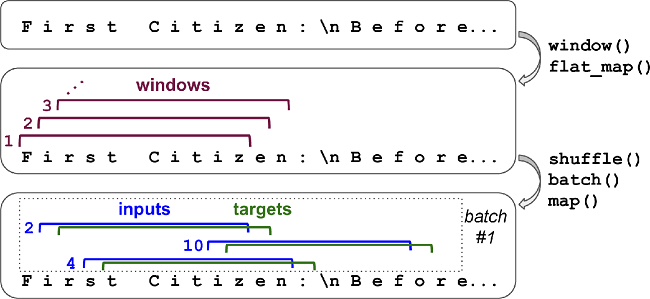
</p>
Figure 16-1. Preparing a dataset of shuffled windows

As discussed in Chapter 13, categorical input features should generally be encoded, usually as one-hot vectors or as embeddings. Here, we will encode each character using a one-hot vector because there are fairly few distinct characters (only 39):

In [14]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

Finally, we just need to add prefetching:

In [15]:
dataset = dataset.prefetch(1)

In [16]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


## Building and Training the Char-RNN Model

To **predict the next character based on the previous 100 characters,** we can use an **RNN with 2 GRU layers of 128 units** each and **20% dropout** on both the **inputs (dropout)** and the **hidden states (recurrent_dropout)**

The output layer is a time distributed Dense layer like we saw in Chapter 15. This time this **layer must have 39 units** (max_id) **because there are 39 distinct characters in the text,** and we want to **output a probability for each possible character** (at each time step)

The **output probabilities should sum up to 1** at each time step, so we apply the **softmax activation function** to the outputs of the Dense layer

We can then compile this model, using the **'sparse_categorical_crossentropy' loss and an Adam optimizer.** Finally, we are ready to train the model for several epochs

Finally, we are ready to train the model for several epochs (this may take many hours, depending on your hardware):

In [17]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
#history = model.fit(dataset, epochs=2) # 10 epochs originally, changed to 2 epochs for less training time since each epoch takes ~ 2 hours
#model.save('ch16_char_rnn.h5')

```
Epoch 1/2
31368/31368 [==============================] - 1632s 52ms/step - loss: 1.6199
Epoch 2/2
31368/31368 [==============================] - 1645s 52ms/step - loss: 1.5386
```



Trained and Uploaded Model on Github

In [18]:
from urllib import request
url = 'https://github.com/lucaslokchan/ml-journal/raw/master/Hands-On%20Machine%20Learning/Model/CH16_CHAR_RNN.h5'
request.urlretrieve(url, 'CH16_CHAR_RNN.h5')

('CH16_CHAR_RNN.h5', <http.client.HTTPMessage at 0x7f91e1faf650>)

In [19]:
model = keras.models.load_model('CH16_CHAR_RNN.h5')

## Using the Char-RNN Model

Now we have a model that can predict the next character in text written by Shakespeare. To feed it some text, we first need to preprocess it like we did earlier, so let’s create a little function for this:

In [20]:
def preprocess(texts):
  X = np.array(tokenizer.texts_to_sequences(texts)) - 1
  return tf.one_hot(X, max_id)

Now let’s use the model to predict the next letter in some text:

In [21]:
# The predict_classes() method is deprecated. Instead, we must use np.argmax(model(X_new), axis=-1)
X_new = preprocess(['How are yo'])
Y_pred = np.argmax(model(X_new), axis=-1)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

'u'

Success! The model guessed right. Now let’s use this model to generate new text

## Generating Fake Shakespearean Text

To generate new text using the Char-RNN model, we could **feed it some text, make the model predict the most likely next letter, add it at the end of the text, then give the extended text to the model to guess the next letter,** and so on

But in practice this often **leads to the same words being repeated over and over again.** Instead, we can **pick the next character randomly,** with a **probability equal to the estimated probability,** using TensorFlow’s tf.random.categorical() function. This will generate **more diverse** and interesting text

The **categorical() function samples random class indices, given the class log probabilities (logits).** To have **more control over the diversity** of the generated text, we can **divide the logits by a number called the temperature,** which we can tweak as we wish: a **temperature close to 0 will favor the high-probability characters,** while a **very high temperature will give all characters an equal probability**

The following next_char() function uses this approach to pick the next character to add to the input text:

In [22]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

Next, we can write a small function that will **repeatedly call next_char()** to get the next character and append it to the given text:

In [23]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

We are now ready to generate some text! Let's try with different temperatures:

In [24]:
print(complete_text('I',n_chars=150, temperature=0.2))

In the countey.

petruchio:
sir, i will go the younger than a words and well access to her
to see the comes of signior gremio.

gremio:
o this is it is


In [25]:
print(complete_text('Hello', n_chars=150, temperature=1))

Hellows of mine;
is't with mike! so'c the thoughts:
as silecied prores more beholding louds:
will occess you, sootmat quace that great
as well to humble th


In [26]:
print(complete_text('Diu', n_chars=150, temperature=2))

Diuit'?
begrae movrob yo;
abteggs to thiw, masterufterframe?.
biomha'ts, sinceivy faicon with
for my cks'luwke'p-,'' legune whaw
to ppo them wiva.
semuut


Apparently our Shakespeare model works best at a temperature close to 1 

To **generate more convincing text,** you could try using **more GRU layers** and more neurons per layer, **train for longer,** and add some **regularization** (for example, you could set recurrent_dropout=0.3 in the GRU layers)

Moreover, the model is currently incapable of learning patterns longer than n_steps, which is just 100 characters. You could try **making this window larger, but it will also make training harder,** and even **LSTM and GRU cells cannot handle very long sequences.** Alternatively, you could use a stateful RNN

## Stateful RNN

Until now, we have used only **stateless RNNs: at each training iteration the model starts with a hidden state full of zeros, then it updates this state at each time step, and after the last time step, it throws it away,** as it is not needed anymore

What if we **told the RNN to preserve this final state after processing one training batch** and **use it as the initial state for the next training batch?** This way the **model can learn long-term patterns despite only backpropagating through short sequences.** This is called a stateful RNN. Let’s see how to build one

First, note that **a stateful RNN only makes sense if each input sequence in a batch starts exactly where the corresponding sequence in the previous batch left off**

So the **first thing** we need to **do to build a stateful RNN** is to **use sequential and nonoverlapping input sequences (rather than the shuffled and overlapping sequences** we used to train stateless RNNs)

When creating the Dataset, we must therefore use shift=n_steps (instead of shift=1) when calling the window() method. Moreover, we must obviously not call the shuffle() method

Unfortunately, batching is much harder when preparing a dataset for a stateful RNN than it is for a stateless RNN. Indeed, **if we were to call batch(32),** then **32 consecutive windows would be put in the same batch, and the following batch would not contiune each of these window where it left off**

The **first batch would contain windows 1 to 32** and the **second batch would contain windows 33 to 64,** so if you consider, say, the **first window of each batch** (i.e., windows 1 and 33), you can see that they are **not consecutive**

**The simplest solution to this problem is to just use "batches" containing a single window:**

In [27]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

Figure 16-2 summarizes the first steps

<p align='center'>
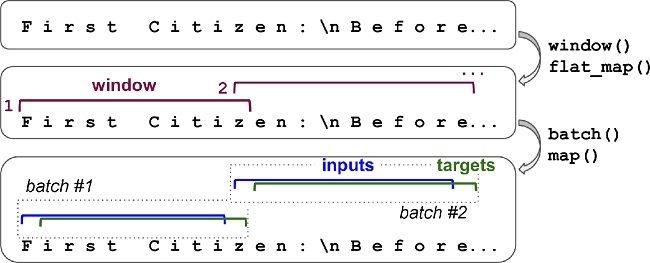
</p>
Figure 16-2. Preparing a dataset of consecutive sequence fragments for a stateful RNN

Batching is harder, but it is not impossible. For example, we could **chop Shakespeare’s text into 32 texts of equal length,** create one dataset of consecutive input sequences for each of them, and finally use tf.train.Dataset.zip(datasets).map(lambda *windows: tf.stack(windows)) to create proper consecutive batches, where the **$n^{th}$ input sequence** in a batch **starts off exactly where the $n^{th}$ input sequence ended in the previous batch**

In [29]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

Now let’s create the stateful RNN. First, we need to set **statsful=True** when creating every recurrent layer. Second, the **stateful RNN needs to know the batch size** (since it will preserve a state for each input sequence in the batch), so we** must set the batch_input_shape argument in the first layer**

Note that we can leave the second dimension unspecified, since the inputs could have any length:

In [32]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation='softmax'))
])

At the **end of each epoch, we need to reset the states before we go back to the beginning of the text.** For this, we can use a small callback:

In [33]:
class ResetStatesCallback(keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    self.model.reset_states()

And now we can compile and fit the model (for more epochs, because each epoch is much shorter than earlier, and there is only one instance per batch):

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
#history = model.fit(dataset, epochs=50,
#                    callbacks=[ResetStatesCallback()])

In [37]:
from urllib import request
url = 'https://github.com/lucaslokchan/ml-journal/raw/master/Hands-On%20Machine%20Learning/Model/CH16_CHAR_RNN_STATEFUL.h5'
request.urlretrieve(url, 'CH16_CHAR_RNN_STATEFUL.h5')

('CH16_CHAR_RNN_STATEFUL.h5', <http.client.HTTPMessage at 0x7f91dff5ee50>)

In [38]:
model = keras.models.load_model('CH16_CHAR_RNN_STATEFUL.h5')

Now that we have built a character-level model, it’s time to look at **word level models** and tackle a common natural language processing task: **sentiment analysis**

# Sentiment Analysis

If MNIST is the “hello world” of computer vision, then the **IMDb reviews dataset is the “hello world” of natural language processing:** it consists of 50,000 movie reviews in English (25,000 for training, 25,000 for testing) extracted from the famous Internet Movie Database, along with a simple binary target for each review **indicating whether it is negative (0) or positive (1)**

Keras provides a simple function to load it

In [40]:
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data()

17473536/17464789 [==============================] - 0s 0us/step


In [43]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

The dataset is already preprocessed for you: X_train consists of a list of reviews, each of which is represented as a NumPy array of integers, where **each integer represents a word**

**All punctuation was removed, and then words were converted to lowercase, split by spaces, and finally indexed by frequency** (so low integers correspond to frequent words)

The integers **0, 1, and 2** are special: they represent the **padding token, the start-of-sequence (SSS) token, and unknown words,** respectively. If you want to visualize a review, you can decode it like this:

In [44]:
word_index = keras.datasets.imdb.get_word_index()

1654784/1641221 [==============================] - 0s 0us/step


In [49]:
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(('<pad>', '<sos>', '<unk>')):
  id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

'<sos> this film was just brilliant casting location scenery story'

In a real project, you will have to preprocess the text yourself. You can do that using the same Tokenizer class we used earlier, but this time setting char_level=False (which is the default)

**When encoding words, it filters out a lot of characters, including most punctuation, line breaks, and tabs** (but you can change this by setting the filter argument)

Most importantly, it uses **spaces to identify word boundaries.** This is OK for English and many other scripts (written languages) that use spaces between words, but not all scripts use spaces this way

Chinese does not use spaces between words, Vietnamese uses spaces even within words, and languages such as German often attach multiple words together, without spaces. Even in English, spaces are not always the best way to tokenize text: think of “San Francisco” or “#ILoveDeepLearning.”



